**CLASIFICACIÓN DE CACAO POR ETAPAS DE MADURACIÓN**

Este proyecto tiene como objetivo clasificar imágenes de cacao, de acuerdo a sus etapas de maduración. Se presentan en 4 diferentes etapas; la primera de cero-dos meses; la segunda de dos-cuatro meses; la tercera de cuatro-seis meses; la cuarta de seis meses en adelante. 
Esto cobra importancia en diversos sectores como la agricultura y la investigación. Dado que se pude tener un mayor control y una planeación de los cultivos de cacao y sirve para el estudio de los mismos.

In [ ]:
# Se instalan librerías
%pip install pycocotools 
%pip install scikit-learn

Se crea el data frame llamado df, el cual contiene la información de las imágenes. Posteriormente se divide en tres conjuntos; test, validación y entrenamiento. Se dividieron de la siguiente manera; Train: 2795 imágenes; Validación: 597 imágenes y Test: 597 imágenes. Se balancearon las imágenes para que cada clase contenga aproximadamente la misma cantidad, usando operaciones como rotación, translación, etc. Por último, el data frame queda conformado con la siguiente información: image_id (clave primaria), file_name (nombre del archivo), path (ruta), width y height (medidas), categories, class_name y class_number.

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image
import cv2 

def load_custom_dataset(base_path, folder_names):
    """
    Carga datasets COCO desde la estructura específica de carpetas.
    
    Parameters:
    base_path (str): Ruta base (RipSetCocoaCNCH12/RipSetCocoaCNCH12/COCO_10)
    folder_names (list): Lista de nombres de carpetas (images_C1, images_C2, etc.)
    
    Returns:
    pandas.DataFrame: DataFrame consolidado con toda la información
    """
    all_image_data = []
    
    # Imprimir las rutas para debug
    print(f"Ruta base: {base_path}")
    print("Carpetas a procesar:", folder_names)
    
    for folder_name in folder_names:
        # Construir rutas
        images_path = os.path.join(base_path, folder_name)
        annotation_path = os.path.join(base_path, f'{folder_name}.json')
        
        print(f"\nProcesando carpeta: {folder_name}")
        print(f"Ruta de imágenes: {images_path}")
        print(f"Ruta de anotaciones: {annotation_path}")
        
        try:
            # Verificar si el archivo JSON existe
            if not os.path.exists(annotation_path):
                print(f"¡Advertencia! No se encontró el archivo: {annotation_path}")
                continue
                
            # Cargar archivo JSON
            with open(annotation_path, 'r') as f:
                coco_data = json.load(f)
            
            print(f"JSON cargado exitosamente para {folder_name}")
            
            # Crear diccionario de categorías
            categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
            
            # Crear diccionario de imágenes
            images = {img['id']: img for img in coco_data['images']}
            
            # Organizar anotaciones por imagen
            image_annotations = {}
            for ann in coco_data['annotations']:
                img_id = ann['image_id']
                if img_id not in image_annotations:
                    image_annotations[img_id] = set()
                image_annotations[img_id].add(categories[ann['category_id']])
            
            # Obtener el número de clase del nombre de la carpeta
            class_number = int(folder_name.split('_C')[1])
            
            # Preparar datos para el DataFrame
            for img_id, annotations in image_annotations.items():
                img_info = images[img_id]
                image_entry = {
                    'image_id': img_id,
                    'file_name': img_info['file_name'],
                    'path': os.path.join(images_path, img_info['file_name']),
                    'width': img_info.get('width', None),
                    'height': img_info.get('height', None),
                    'categories': list(annotations),
                    'class_name': folder_name,  # Guardamos el nombre de la carpeta
                    'class_number': class_number  # Guardamos el número de clase
                }
                all_image_data.append(image_entry)
            
            print(f"Procesadas {len(image_annotations)} imágenes de {folder_name}")
                
        except Exception as e:
            print(f"Error procesando {folder_name}: {str(e)}")
    
    # Crear DataFrame consolidado
    if not all_image_data:
        raise ValueError("No se encontraron datos en ninguna carpeta")
    
    df = pd.DataFrame(all_image_data)
    return df


In [ ]:
def create_train_val_test_split(df, val_size=0.15, test_size=0.15, seed=42):
    """
    Crea splits estratificados manteniendo la distribución de clases.
    """
    np.random.seed(seed)
    
    train_data, val_data, test_data = [], [], []
    
    # Procesar por clase
    for class_name in df['class_name'].unique():
        class_data = df[df['class_name'] == class_name]
        
        # Calcular tamaños
        n_samples = len(class_data)
        n_test = int(n_samples * test_size)
        n_val = int(n_samples * val_size)
        
        # Dividir los datos
        shuffled = class_data.sample(frac=1, random_state=seed)
        train_data.append(shuffled[:(n_samples-n_test-n_val)])
        val_data.append(shuffled[(n_samples-n_test-n_val):(n_samples-n_test)])
        test_data.append(shuffled[(n_samples-n_test):])
    
    # Combinar los datos
    train_df = pd.concat(train_data).reset_index(drop=True)
    val_df = pd.concat(val_data).reset_index(drop=True)
    test_df = pd.concat(test_data).reset_index(drop=True)
    
    return train_df, val_df, test_df

def verify_dataset(df):
    """
    Verifica la integridad del dataset.
    """
    verification = {
        'total_images': len(df),
        'images_per_class': df['class_name'].value_counts().to_dict(),
        'missing_images': [],
        'categories_per_class': {}
    }
    
    # Verificar que las imágenes existen
    for idx, row in df.iterrows():
        if not os.path.exists(row['path']):
            verification['missing_images'].append(row['path'])
    
    # Analizar categorías por clase
    for class_name in df['class_name'].unique():
        class_data = df[df['class_name'] == class_name]
        categories = [cat for cats in class_data['categories'] for cat in cats]
        verification['categories_per_class'][class_name] = pd.Series(categories).value_counts().to_dict()
    
    return verification

In [ ]:
# 1. Definir las rutas
ruta_1 = 'C://Users//user//OneDrive//Escritorio//VISION ARTIFICIAL//RipSetCocoaCNCH12//COCO_10'
ruta_2 = ['images_C1','images_C2','images_C3','images_C4']

# 2. Cargar el dataset
try:
    df = load_custom_dataset(ruta_1, ruta_2)
    
    # 3. Verificar la integridad del dataset
    verification = verify_dataset(df)
    print("\nEstadísticas del dataset:")
    print(f"Total de imágenes: {verification['total_images']}")
    print("\nImágenes por clase:")
    for class_name, count in verification['images_per_class'].items():
        print(f"{class_name}: {count}")

    if verification['missing_images']:
        print("\n¡Advertencia! Imágenes faltantes:", len(verification['missing_images']))

    # 4. Crear los splits
    train_df, val_df, test_df = create_train_val_test_split(df)

    # 5. Ver distribución final
    print("\nDistribución final:")
    print(f"Train: {len(train_df)} imágenes")
    print(f"Validación: {len(val_df)} imágenes")
    print(f"Test: {len(test_df)} imágenes")

except Exception as e:
    print(f"Error en el proceso: {str(e)}")

In [ ]:

train_df.head()

Se toman 10 imágenes de manera aleatoria y se fijan para posteriormente realizar muestras con ellas.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Seleccionar 10 imágenes aleatorias
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(15, 10))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):  # Desempaquetar directamente
    img_path = row['path']  # Ruta de la imagen
    
    try:
        img = Image.open(img_path)  # Abrir la imagen
        plt.subplot(2, 5, i + 1)  # Crear subgráficos (2 filas, 5 columnas)
        plt.imshow(img)  # Mostrar la imagen
        plt.axis('off')  # Ocultar ejes
        plt.title(row['class_name'])  # Mostrar la categoría como título
    except Exception as e:
        print(f"Error al cargar {img_path}: {e}")

plt.tight_layout()
plt.show()



**EXPLORAMOS EL CANAL HSV**

Mostramos cada canal H (Hue), S (Saturation) y V (Value)

In [ ]:
# Modificar el tamaño del lienzo para acomodar más imágenes
plt.figure(figsize=(20, 15))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen
    
    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue
        
        # Convertir la imagen de BGR a RGB para mostrar correctamente con matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Convertir la imagen al espacio de color HSV
        img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        
        # Separar los canales H, S y V
        h, s, v = cv2.split(img_hsv)
        
        # Mostrar la imagen original
        plt.subplot(5, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")
        
        # Mostrar el canal H
        plt.subplot(5, 10, i + 11)
        plt.imshow(h, cmap='gray')
        plt.axis('off')
        plt.title('Canal H')
        
        # Mostrar el canal S
        plt.subplot(5, 10, i + 21)
        plt.imshow(s, cmap='gray')
        plt.axis('off')
        plt.title('Canal S')
        
        # Mostrar el canal V
        plt.subplot(5, 10, i + 31)
        plt.imshow(v, cmap='gray')
        plt.axis('off')
        plt.title('Canal V')
        
        # Mostrar la imagen HSV convertida a RGB
        img_hsv_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
        plt.subplot(5, 10, i + 41)
        plt.imshow(img_hsv_rgb)
        plt.axis('off')
        plt.title('Imagen HSV')
        
    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()


Ahora aplicaremos un filtro Gaussiano para eliminar el ruido de las imágenes y luego mostrar una comparación entre las imágenes originales y las filtradas, tanto en el espacio de color BGR como en el HSV. También visualizaremos los canales individuales H (Matiz), S (Saturación) y V (Valor) antes y después del filtrado para observar el efecto del filtro en cada canal.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

# Seleccionar 10 imágenes aleatorias del conjunto de entrenamiento
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(30, 30))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen
    
    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue
        
        # Aplicar filtro Gaussiano para reducir el ruido
        img_bgr_filtered = cv2.GaussianBlur(img_bgr, (5, 5), 0)
        
        # Convertir las imágenes de BGR a RGB para mostrar correctamente con matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb_filtered = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2RGB)
        
        # Convertir las imágenes al espacio de color HSV
        img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        img_hsv_filtered = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2HSV)
        
        # Separar los canales H, S y V de las imágenes originales y filtradas
        h_orig, s_orig, v_orig = cv2.split(img_hsv)
        h_filt, s_filt, v_filt = cv2.split(img_hsv_filtered)
        
        # Mostrar la imagen original
        plt.subplot(6, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")
        
        # Mostrar la imagen filtrada
        plt.subplot(6, 10, i + 11)
        plt.imshow(img_rgb_filtered)
        plt.axis('off')
        plt.title('Filtrada')
        
        # Mostrar el canal H original
        plt.subplot(6, 10, i + 21)
        plt.imshow(h_orig, cmap='gray')
        plt.axis('off')
        plt.title('Canal H Original')
        
        # Mostrar el canal H filtrado
        plt.subplot(6, 10, i + 31)
        plt.imshow(h_filt, cmap='gray')
        plt.axis('off')
        plt.title('Canal H Filtrado')
        
        # Mostrar la imagen HSV original convertida a RGB
        img_hsv_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
        plt.subplot(6, 10, i + 41)
        plt.imshow(img_hsv_rgb)
        plt.axis('off')
        plt.title('Original HSV')
        
        # Mostrar la imagen HSV filtrada convertida a RGB
        img_hsv_filt_rgb = cv2.cvtColor(img_hsv_filtered, cv2.COLOR_HSV2RGB)
        plt.subplot(6, 10, i + 51)
        plt.imshow(img_hsv_filt_rgb)
        plt.axis('off')
        plt.title('Filtrada HSV')
        
    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()


HISTOGRAMA:
Mostramos el histograma de las imagenes HSV filtradas para ver la frecuencia y matiz  en las imagenes y así elegir los umbrales de segmentación con un mayor criterío de decisión.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Seleccionar una muestra de imágenes
sample_images = train_df.sample(n=5, random_state=42)  # Puedes ajustar 'n' según tus necesidades

# Crear listas para almacenar los valores de los canales
hist_h = []
hist_s = []
hist_v = []

# Iterar sobre las imágenes seleccionadas
for idx, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']
    
    # Cargar la imagen
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"No se pudo cargar la imagen: {img_path}")
        continue
    
    # Aplicar filtro Gaussiano
    img_filtered = cv2.GaussianBlur(img_bgr, (5, 5), 0)
    
    # Convertir al espacio HSV
    img_hsv = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2HSV)
    
    # Separar los canales
    h, s, v = cv2.split(img_hsv)
    
    # Calcular histogramas
    hist_h_values, _ = np.histogram(h, bins=180, range=(0, 179))
    hist_s_values, _ = np.histogram(s, bins=256, range=(0, 255))
    hist_v_values, _ = np.histogram(v, bins=256, range=(0, 255))
    
    # Agregar los histogramas a las listas
    hist_h.append(hist_h_values)
    hist_s.append(hist_s_values)
    hist_v.append(hist_v_values)
    
    # Mostrar la imagen y su histograma
    plt.figure(figsize=(12, 6))
    
    # Mostrar la imagen filtrada
    plt.subplot(1, 2, 1)
    img_rgb = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Imagen Filtrada\n{row['class_name']}")
    
    # Mostrar el histograma de Matiz (H)
    plt.subplot(1, 2, 2)
    plt.plot(hist_h_values, color='red')
    plt.title('Histograma del Canal H (Matiz)')
    plt.xlabel('Valores de Matiz')
    plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
# Calcular el histograma promedio
avg_hist_h = np.mean(hist_h, axis=0)
avg_hist_s = np.mean(hist_s, axis=0)
avg_hist_v = np.mean(hist_v, axis=0)

# Mostrar los histogramas promedio
plt.figure(figsize=(18, 5))

# Histograma del canal H (Matiz)
plt.subplot(1, 3, 1)
plt.plot(range(180), avg_hist_h, color='red')
plt.title('Histograma Promedio del Canal H (Matiz)')
plt.xlabel('Valores de Matiz')
plt.ylabel('Frecuencia')

# Histograma del canal S (Saturación)
plt.subplot(1, 3, 2)
plt.plot(range(256), avg_hist_s, color='green')
plt.title('Histograma Promedio del Canal S (Saturación)')
plt.xlabel('Valores de Saturación')
plt.ylabel('Frecuencia')

# Histograma del canal V (Valor)
plt.subplot(1, 3, 3)
plt.plot(range(256), avg_hist_v, color='blue')
plt.title('Histograma Promedio del Canal V (Valor)')
plt.xlabel('Valores de Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


**TIPOS DE SEGMENTACIÓN**

Ahora realizaremos varios tipos de segmentación en la muestra de imagenes para verificar la mas apropiada según nuestro criterio.

SEGMENTACIÓN POR UMBRALIZACIÓN:

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Definir los rangos de HSV para la segmentación
# Ajusta estos valores según el color que deseas segmentar
# Por ejemplo, para segmentar tonos amarillos/rojizos:
h_min = 0
h_max = 30
s_min = 100
s_max = 255
v_min = 100
v_max = 255

# Seleccionar 10 imágenes aleatorias del conjunto de entrenamiento
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(20, 20))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen

    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue

        # Aplicar filtro Gaussiano para reducir el ruido
        img_bgr_filtered = cv2.GaussianBlur(img_bgr, (5, 5), 0)

        # Convertir la imagen filtrada al espacio de color HSV
        img_hsv_filtered = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2HSV)

        # Definir el rango para la segmentación
        lower_hsv = np.array([h_min, s_min, v_min])
        upper_hsv = np.array([h_max, s_max, v_max])

        # Aplicar la umbralización para crear una máscara
        mask = cv2.inRange(img_hsv_filtered, lower_hsv, upper_hsv)

        # Aplicar operaciones morfológicas para mejorar la máscara
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Aplicar la máscara a la imagen original
        result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

        # Convertir imágenes a RGB para Matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_filtered_rgb = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2RGB)
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original
        plt.subplot(4, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")

        # Mostrar la imagen filtrada
        plt.subplot(4, 10, i + 11)
        plt.imshow(img_filtered_rgb)
        plt.axis('off')
        plt.title('Filtrada')

        # Mostrar la máscara
        plt.subplot(4, 10, i + 21)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Máscara')

        # Mostrar el resultado de la segmentación
        plt.subplot(4, 10, i + 31)
        plt.imshow(result_rgb)
        plt.axis('off')
        plt.title('Segmentada')

    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()
    

SEGMENTACIÓN POR CLUSTERING:

K-MEANS: Este algoritmo agrupa los píxeles en clusters basados en sus características de color. Puede ser útil para segmentar diferentes partes de la imagen según colores similares.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Seleccionar 10 imágenes aleatorias del conjunto de entrenamiento
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(20, 20))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen

    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue

        # Aplicar filtro Gaussiano para reducir el ruido
        img_bgr_filtered = cv2.GaussianBlur(img_bgr, (5, 5), 0)

        # Convertir la imagen filtrada al espacio de color HSV
        img_hsv_filtered = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2HSV)

        # Reshape the image to a 2D array of pixels and 3 color values (HSV)
        pixel_values = img_hsv_filtered.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Define criteria and apply kmeans()
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        k = 3  # Number of clusters (you can adjust this value)
        _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert back to 8 bit values
        centers = np.uint8(centers)
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(img_hsv_filtered.shape)

        # Convert segmented image back to BGR color space
        segmented_image_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_HSV2BGR)

        # Convert images to RGB for Matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_filtered_rgb = cv2.cvtColor(img_bgr_filtered, cv2.COLOR_BGR2RGB)
        segmented_rgb = cv2.cvtColor(segmented_image_bgr, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original
        plt.subplot(4, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")

        # Mostrar la imagen filtrada
        plt.subplot(4, 10, i + 11)
        plt.imshow(img_filtered_rgb)
        plt.axis('off')
        plt.title('Filtrada')

        # Mostrar la imagen segmentada por K-means
        plt.subplot(4, 10, i + 21)
        plt.imshow(segmented_rgb)
        plt.axis('off')
        plt.title('Segmentada K-means')

    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()


SEGMENTACIÓN BASADA EN BORDES:

MÉTODO SOBEL: Este método detecta los bordes en la imagen calculando las derivadas en las direcciones horizontal y vertical.


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Seleccionar 10 imágenes aleatorias del conjunto de entrenamiento
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(20, 20))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen

    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue

        # Convertir la imagen a escala de grises
        gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Aplicar filtro Gaussiano para reducir el ruido
        gray_img_filtered = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Aplicar el detector de bordes Sobel
        sobelx = cv2.Sobel(gray_img_filtered, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_img_filtered, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Normalizar la magnitud de los bordes
        sobel_edges = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX)
        sobel_edges = sobel_edges.astype(np.uint8)

        # Aplicar umbralización para obtener una máscara binaria de bordes
        _, mask = cv2.threshold(sobel_edges, 50, 255, cv2.THRESH_BINARY)

        # Aplicar operaciones morfológicas para mejorar la máscara de bordes
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Aplicar la máscara a la imagen original
        result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

        # Convertir imágenes a RGB para Matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original
        plt.subplot(4, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")

        # Mostrar la imagen filtrada
        plt.subplot(4, 10, i + 11)
        plt.imshow(gray_img_filtered, cmap='gray')
        plt.axis('off')
        plt.title('Gris Filtrada')

        # Mostrar la máscara de bordes
        plt.subplot(4, 10, i + 21)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Máscara Bordes')

        # Mostrar el resultado de la segmentación
        plt.subplot(4, 10, i + 31)
        plt.imshow(result_rgb)
        plt.axis('off')
        plt.title('Segmentada Sobel')

    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()


MÉTODO CANNY:
Este método detecta los bordes en la imagen basándose en gradientes de intensidad

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Seleccionar 10 imágenes aleatorias del conjunto de entrenamiento
sample_images = train_df.sample(n=10, random_state=42)

# Configurar el tamaño del lienzo
plt.figure(figsize=(20, 20))

# Iterar sobre las imágenes seleccionadas
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']  # Ruta de la imagen

    try:
        # Cargar la imagen utilizando OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error al cargar la imagen: {img_path}")
            continue

        # Convertir la imagen a escala de grises
        gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Aplicar filtro Gaussiano para reducir el ruido
        gray_img_filtered = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Aplicar el detector de bordes Canny
        edges = cv2.Canny(gray_img_filtered, 100, 200)

        # Aplicar operaciones morfológicas para mejorar la máscara de bordes
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # Aplicar la máscara a la imagen original
        result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

        # Convertir imágenes a RGB para Matplotlib
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original
        plt.subplot(4, 10, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Original\n{row['class_name']}")

        # Mostrar la imagen filtrada
        plt.subplot(4, 10, i + 11)
        plt.imshow(gray_img_filtered, cmap='gray')
        plt.axis('off')
        plt.title('Gris Filtrada')

        # Mostrar la máscara de bordes
        plt.subplot(4, 10, i + 21)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Máscara Canny')

        # Mostrar el resultado de la segmentación
        plt.subplot(4, 10, i + 31)
        plt.imshow(result_rgb)
        plt.axis('off')
        plt.title('Segmentada Canny')

    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

plt.tight_layout()
plt.show()


Parte 2
---

In [4]:
import numpy as np
from os import listdir
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
def Cargar_img(directorio: str, img_size: tuple[int, int], color_mode: str, prefijo: str = "images_C"):
    X, y = [], []
    # Obtener solo las carpetas que coincidan con el prefijo
    todas_carpetas = listdir(directorio)
    class_names = [folder for folder in todas_carpetas if folder.startswith(prefijo)]
    print(f"Procesando {len(class_names)} clases: {class_names}")
    
    for i, img_fold in enumerate(class_names):
        folder_path = os.path.join(directorio, img_fold)
        images_path = listdir(folder_path)
        print(f"Carpeta {img_fold}: {len(images_path)} archivos")
        
        valid_count = 0
        for img_name in images_path:
            img_path = os.path.join(directorio, img_fold, img_name)
            try:
                # Verificar extensiones comunes de imágenes
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                    print(f"Omitiendo archivo con extensión no reconocida: {img_path}")
                    continue
                    
                image = tf.keras.utils.load_img(
                    img_path,
                    color_mode=color_mode,
                    target_size=img_size,
                    interpolation="nearest",
                    keep_aspect_ratio=False,
                )
                
                image = tf.keras.utils.img_to_array(image, data_format="channels_last").astype(np.uint8)
                X.append(image)
                y.append(i)
                valid_count += 1
                
            except Exception as e:
                print(f"Error al cargar {img_path}: {str(e)}")
        
        print(f"  - Se cargaron {valid_count} imágenes válidas de {len(images_path)}")
        
    if not X:
        raise ValueError("No se pudo cargar ninguna imagen válida del directorio")
        
    print(f"Total de imágenes cargadas: {len(X)}")
    X = np.array(X)
    y = np.array(y)
    
    # Mezclar los datos
    if len(y) > 0:
        i = np.arange(0, y.shape[0])
        np.random.shuffle(i)
        return X[i], y[i]
    else:
        return np.array([]), np.array([])

In [6]:
X, y = Cargar_img(
    directorio = r"C:\Users\santi\OneDrive\Documents\Universidad\semestre 9\vision artificial\Trabajo\Proyecto_Cocoa_2025\RipSetCocoaCNCH12\COCO_10",
    img_size = (128,128),
    color_mode = "rgb"
)

Procesando 4 clases: ['images_C1', 'images_C2', 'images_C3', 'images_C4']
Carpeta images_C1: 1000 archivos
  - Se cargaron 1000 imágenes válidas de 1000
Carpeta images_C2: 1000 archivos
  - Se cargaron 1000 imágenes válidas de 1000
Carpeta images_C3: 1000 archivos
  - Se cargaron 1000 imágenes válidas de 1000
Carpeta images_C4: 1000 archivos
  - Se cargaron 1000 imágenes válidas de 1000
Total de imágenes cargadas: 4000


In [7]:
clases = ['images_C1', 'images_C2', 'images_C3', 'images_C4']

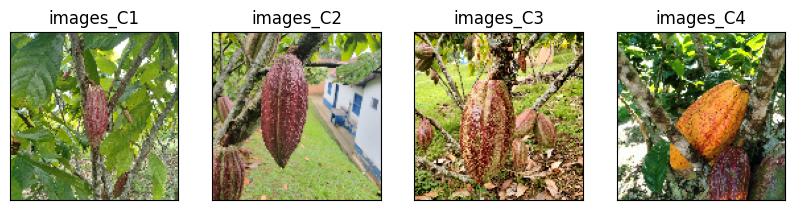

In [8]:
_, axes = plt.subplots(1, 4, figsize=(10,10))
for i in range(len(clases)):
    axes[i].imshow(X[ y == i ][0])
    axes[i].set_title(clases[i])

    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

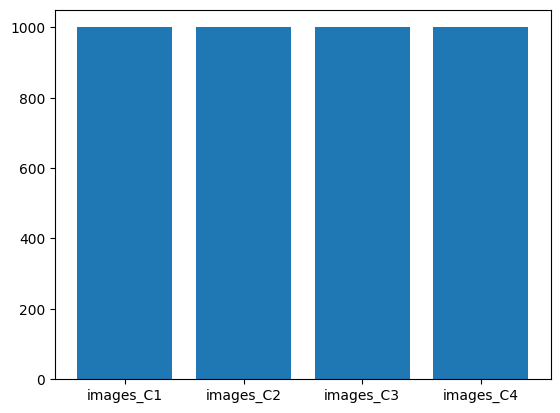

In [9]:
plt.figure()

plt.bar(clases, np.bincount(y))

plt.show()

In [10]:
X_scaled = X / 255

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, stratify=y)

In [12]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(clases), activation='softmax')
])

modelo.summary()

C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,515,588 (112.59 MB)

 Trainable params: 29,514,372 (112.59 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [13]:
tf.keras.utils.plot_model(modelo, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [14]:
train_data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,    # rotar imagenes hasta 45 grados aleatoriamente
    shear_range=0.2,        # mover la imagen para formar un paralelogramo, hasta en un 20% aleatoriamente
    zoom_range=0.2,         # aplicar zoom hasta del 20% aleatoriamente
    horizontal_flip=True,   # rotar horizontalmente la imagen aleatoriamente
    validation_split=0.25   # fraccion de las imagenes que seran usadas para validar el modelo
)

In [15]:
# Compilacion
modelo.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
CB = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
]

# Entrenamiento
history = modelo.fit(
    train_data_augmenter.flow(X_train, y_train, subset="training"),
    validation_data = train_data_augmenter.flow(X_train, y_train, subset="validation"),
    epochs = 60,
    callbacks = CB,
    batch_size = 32,
    validation_batch_size = 32
)

C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 745ms/step - accuracy: 0.5678 - loss: 1.5020 - val_accuracy: 0.2450 - val_loss: 26.2203
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 693ms/step - accuracy: 0.6853 - loss: 0.8184 - val_accuracy: 0.2450 - val_loss: 66.2459
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 754ms/step - accuracy: 0.7289 - loss: 0.7190 - val_accuracy: 0.2450 - val_loss: 118.6969
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 689ms/step - accuracy: 0.7452 - loss: 0.6255 - val_accuracy: 0.2488 - val_loss: 136.1400
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 694ms/step - accuracy: 0.7564 - loss: 0.5868 - val_accuracy: 0.2875 - val_loss: 146.5214
Epoch 6/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 678ms/step - accuracy: 0.7648 - loss: 0.5602 - val_accuracy: 0.3887 - val_loss: 79.4940
Epoch 7/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 698ms/step - accuracy: 0.7682 - loss: 0.5544 - val_accuracy: 0.5387 - val_loss: 22.4748
Epoch 8/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 707ms/step - accuracy: 0.7934 - loss: 0.5602 

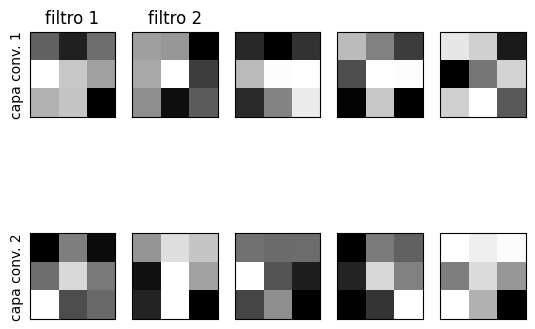

In [16]:
# filtrar capas convolucionales
conv_layers = [layer for layer in modelo.layers if "conv" in layer.name ]

np.random.seed(1)

_, axes = plt.subplots(len(conv_layers), 5)

for i, layer in enumerate(conv_layers):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"filtro {i+1}")

    # obtener los filtros de cada capa convolucional
    filters, biases = layer.get_weights()
    # reescalar filtros para poder ser visualizados
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # obtener 4 filtros al azar para ser visualizados
    sel = np.random.randint(0, filters.shape[-1], 5)
    filters_selected = filters[:,:,:, sel]
    filters_selected = np.moveaxis(filters_selected, -1, 0)
    filters_selected = np.mean(filters_selected, axis=3, keepdims=True)
    # filters_selected = filters_selected[:,:,:,0]
    for j, filter in enumerate(filters_selected):
        # visualizar filtro
        axes[i,j].imshow(filter, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


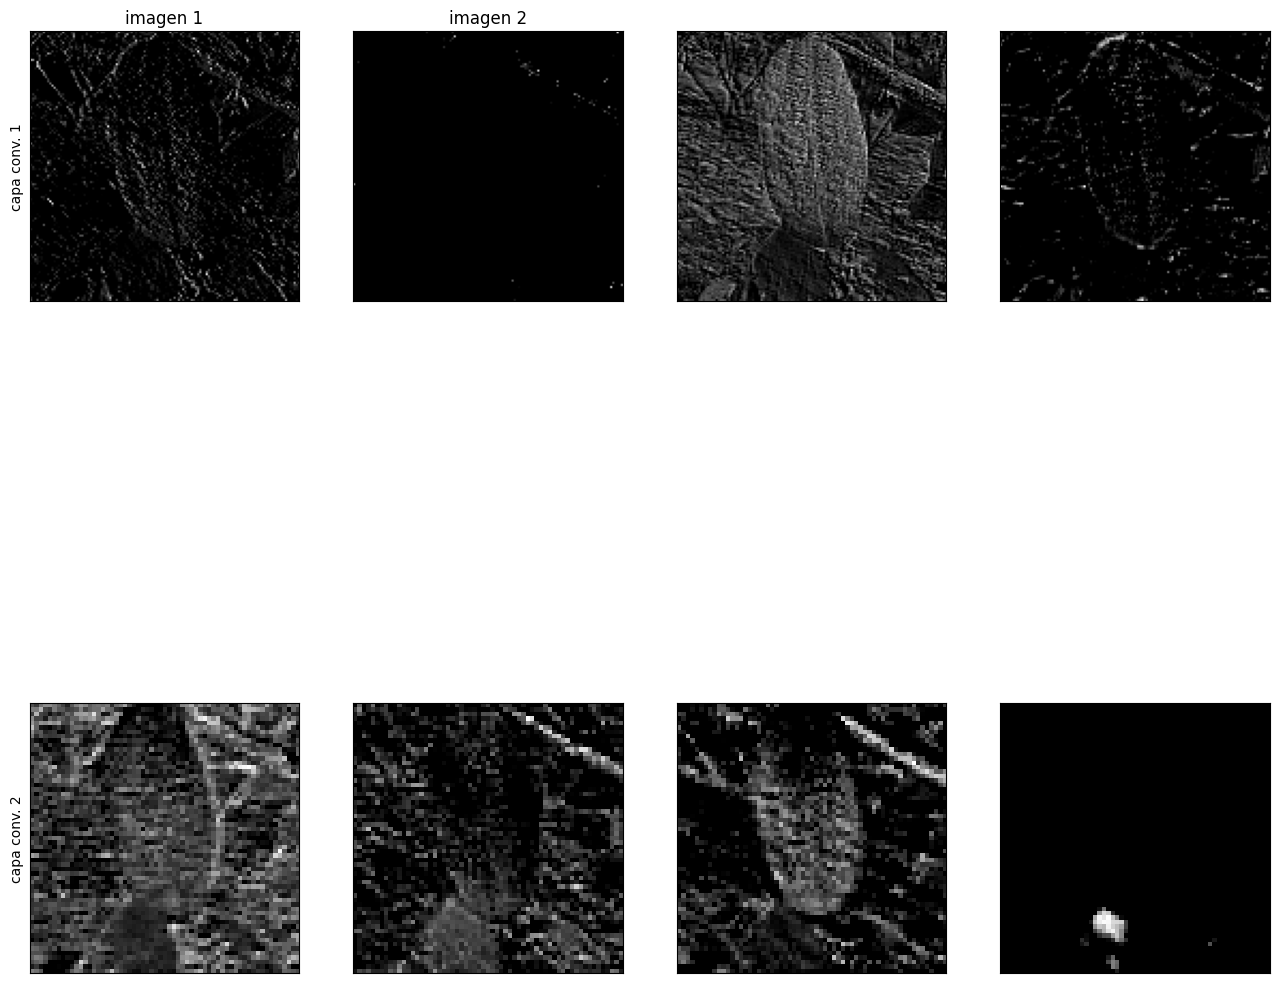

In [17]:
_, axes = plt.subplots(len(conv_layers), 4, figsize=(16,16))

np.random.seed(3)

# modelo que nos dara la salida de cada capa convolucional
vis_model = tf.keras.models.Model(
    inputs = modelo.inputs,
    outputs = [ layer.output for layer in conv_layers ]
)

# aplicar el modelo hasta cada capa convolucional
feature_maps = vis_model.predict(np.expand_dims(X_test[40], axis=0))

for i, f_map in enumerate(feature_maps):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"imagen {i+1}")

    # filtrar imagenes resultantes sin caracteristicas extraidas
    f_map = f_map[:,:,:, np.any(f_map[0,:,:,:] > 0, axis=(0,1)) ]

    # seleccionar 4 imagenes con el filtro aplicado para mostrar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:,:,:, sel]
    feature_map_selected = feature_map_selected[0]
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)
    for j, image in enumerate(feature_map_selected):
        # visualizar imagen
        axes[i,j].imshow(image, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

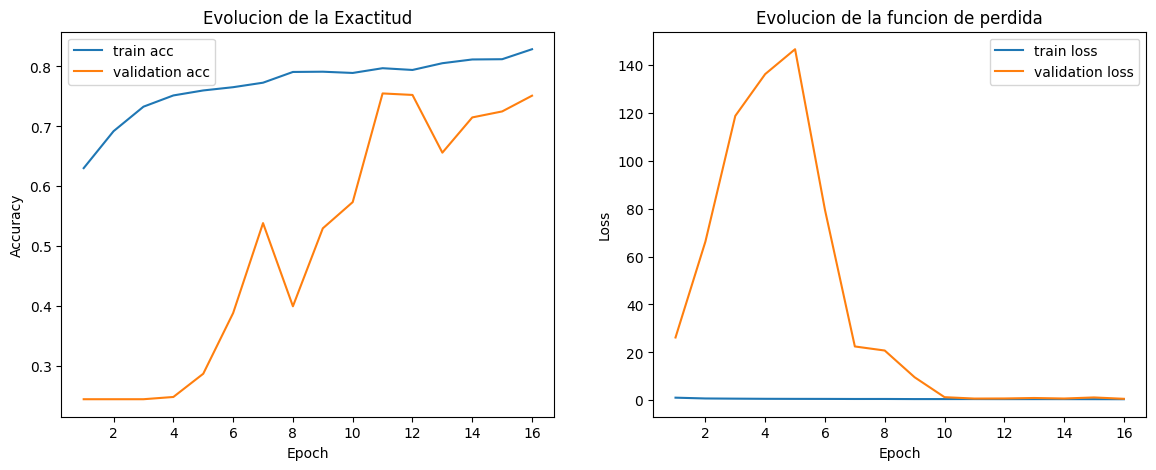

In [20]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
 
# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

In [21]:
import numpy as np
def plot_imagen_classification(modelo, imagen, clases, y_true=None):
    if len(imagen.shape) == 3:
        imagen = np.expand_dims(imagen, axis=0)

    predictions = modelo.predict(imagen)
    predicted_class = np.argmax(predictions)

    fig, (img_ax, prob_ax) = plt.subplots(1, 2, figsize=(10,3))

    img_ax.imshow(imagen[0], cmap=plt.get_cmap('gray'))

    img_ax.xaxis.set_tick_params(labelbottom=False)
    img_ax.yaxis.set_tick_params(labelleft=False)
    img_ax.set_xticks([])
    img_ax.set_yticks([])

    prob_ax.bar(clases, predictions[0], label="otras clases", color="blue")
    prob_ax.bar(clases[predicted_class], predictions[0, predicted_class], label=f"predicha ({clases[predicted_class]})", color="red")

    if y_true != None:
        prob_ax.bar(clases[y_true], predictions[0, y_true], label=f"verdadera ({clases[y_true]})", color="green")

    prob_ax.legend()
    prob_ax.set_ylabel("probabilidad")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


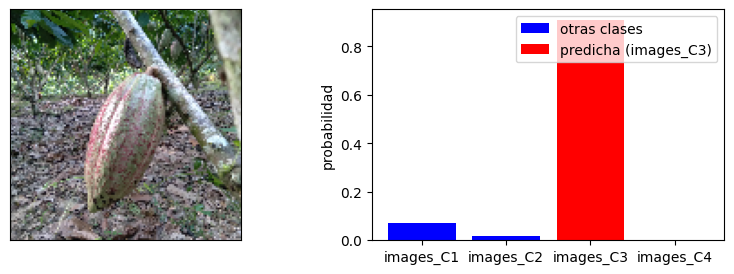

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


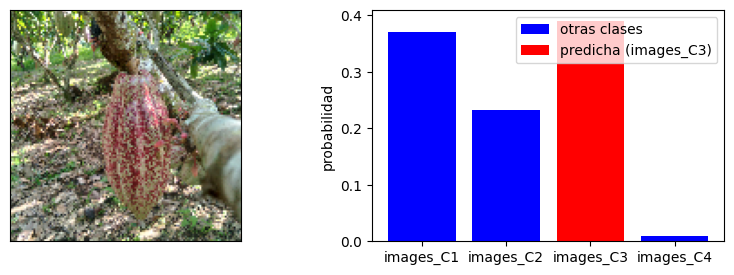

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


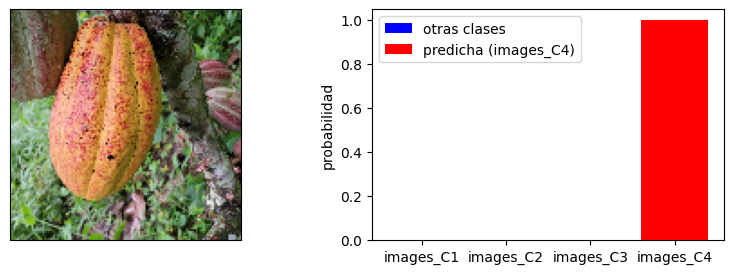

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


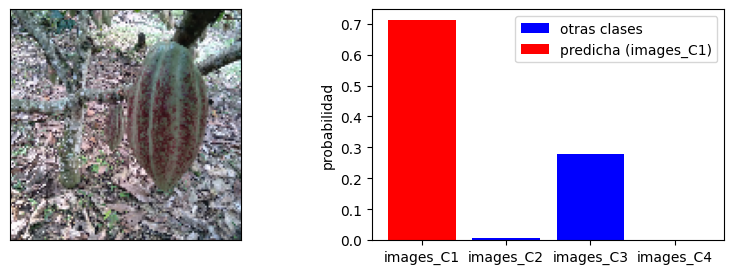

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


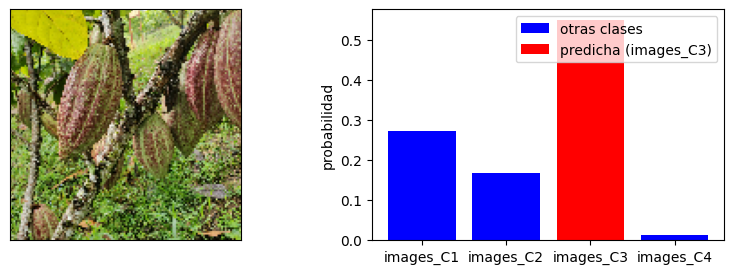

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


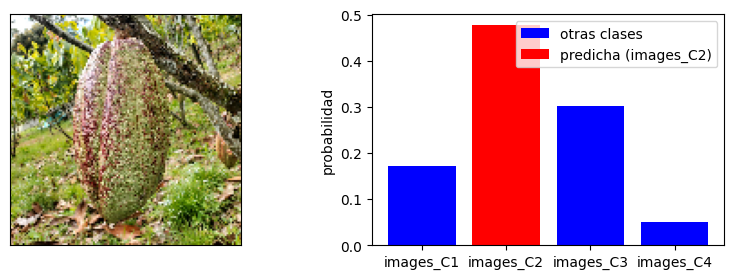

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


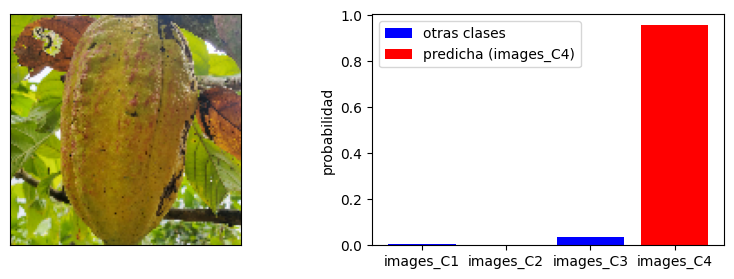

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


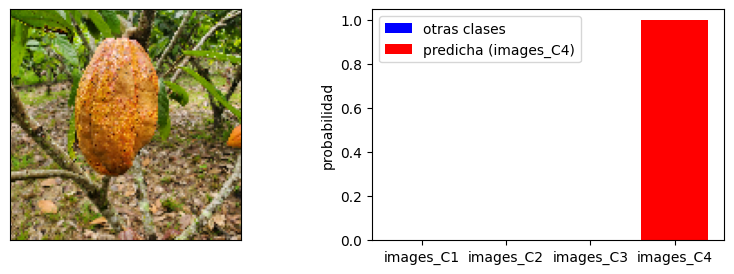

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


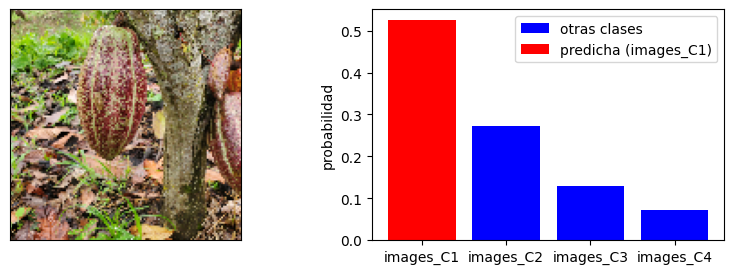

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


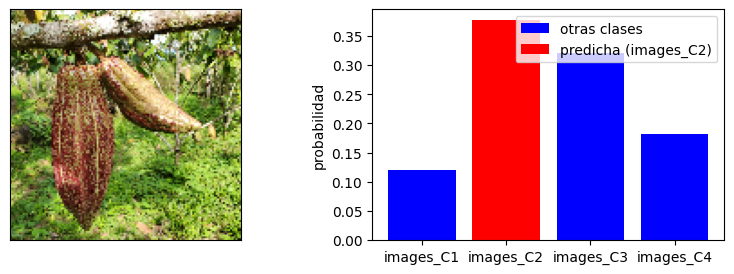

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


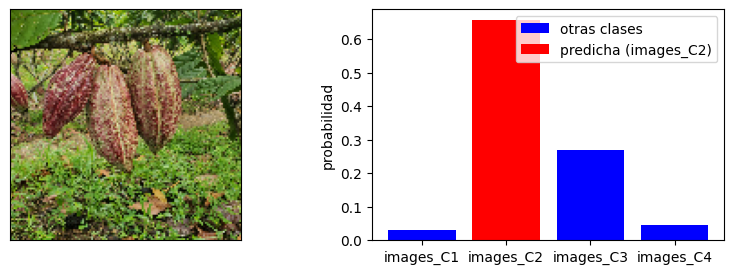

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


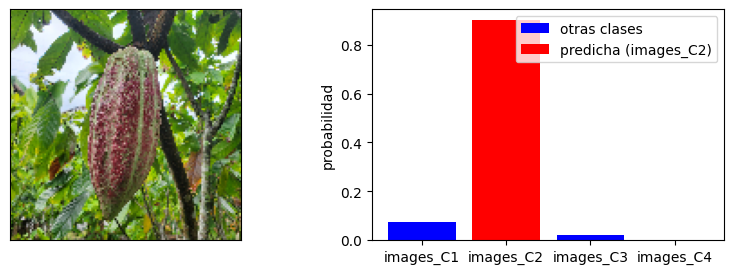

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


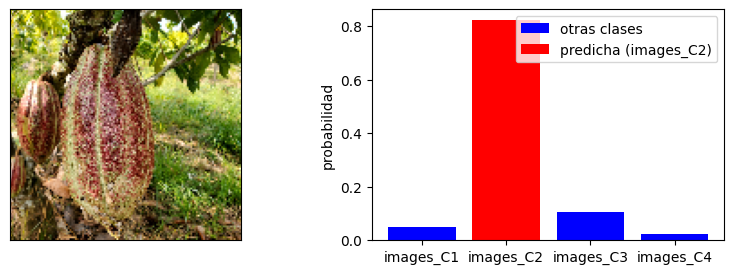

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


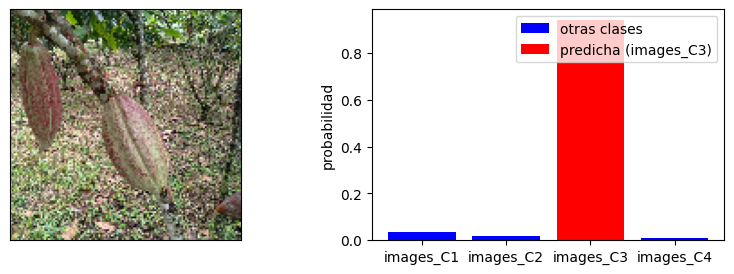

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


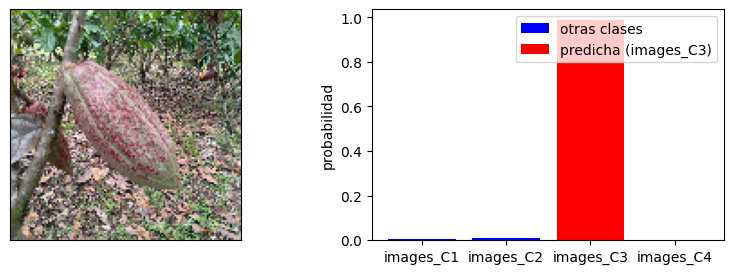

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


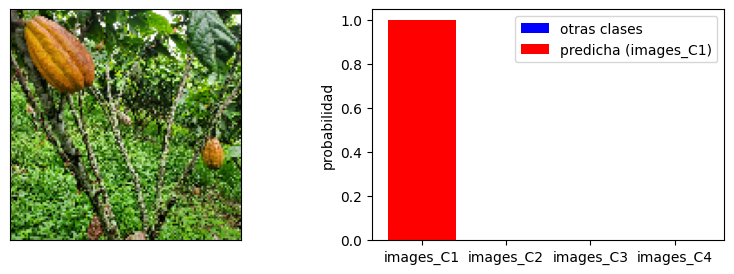

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


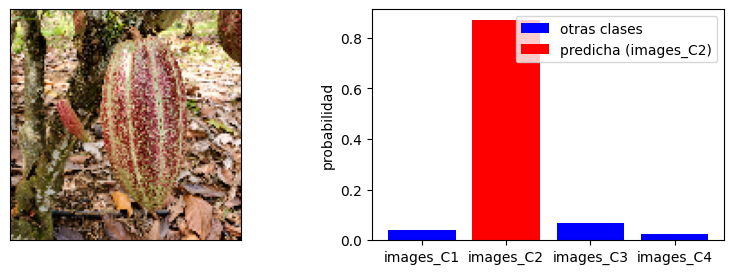

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


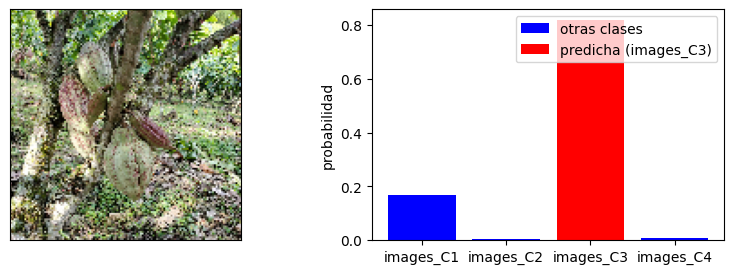

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


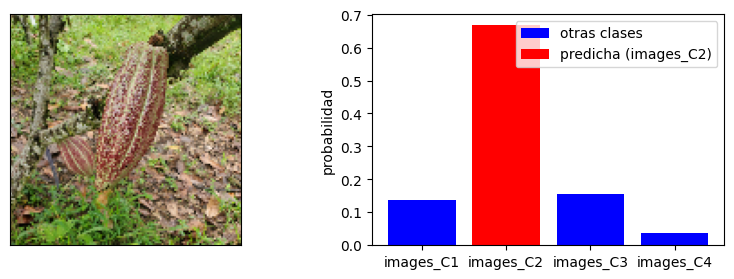

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


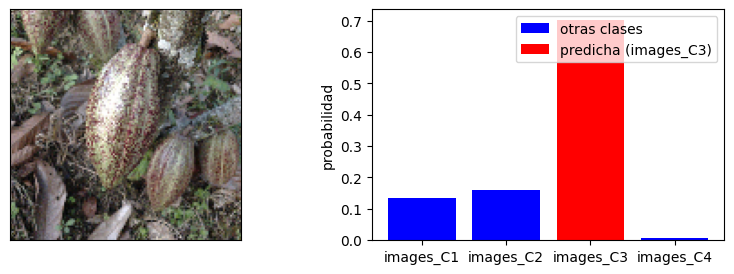

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


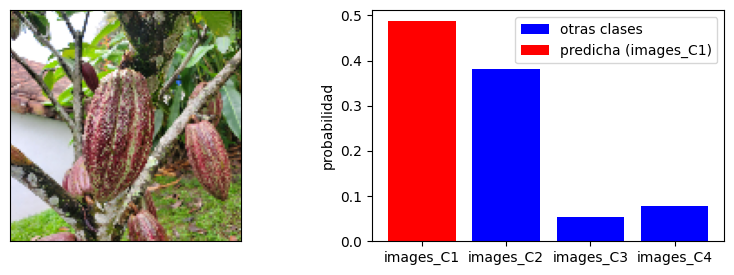

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


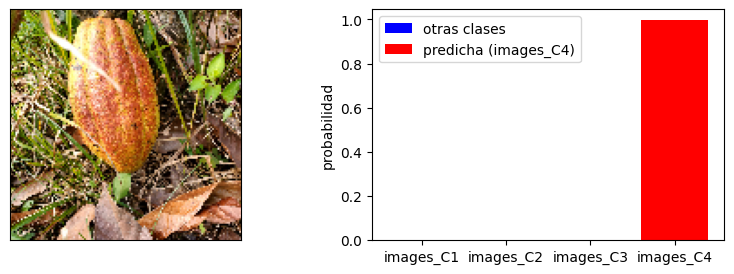

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


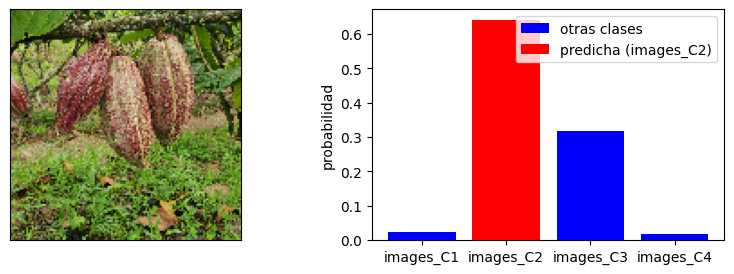

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


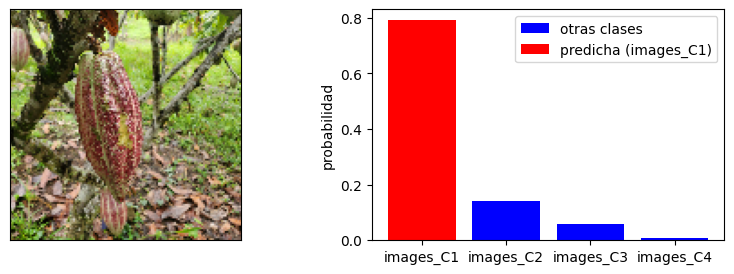

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


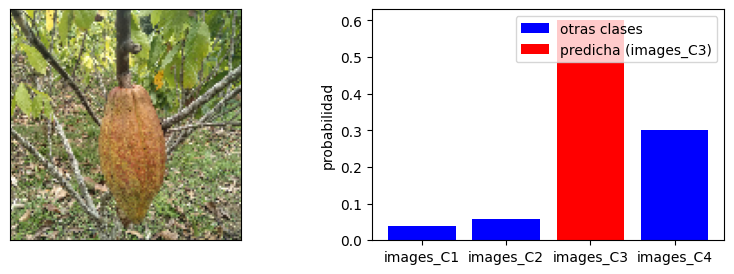

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


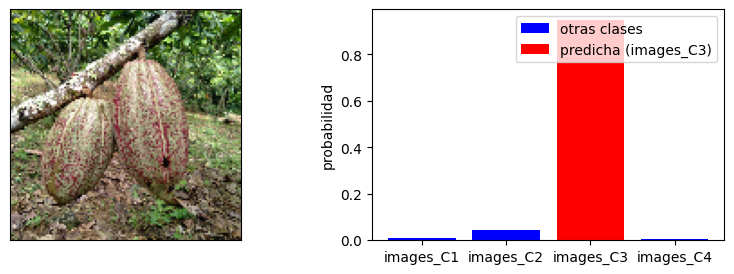

In [22]:
for i in range(100, 126):
  #print(len(x_test[i].shape))
  plot_imagen_classification(modelo, X_test[i], clases)


ENTRENAMIENTO Y VALIDACIÓN:
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
              precision    recall  f1-score   support

   images_C1       0.66      0.80      0.73       800
   images_C2       0.79      0.35      0.48       800
   images_C3       0.63      0.87      0.73       800
   images_C4       0.94      0.91      0.93       800

    accuracy                           0.73      3200
   macro avg       0.76      0.73      0.72      3200
weighted avg       0.76      0.73      0.72      3200


Matriz de Confusión Normalizada (Entrenamiento y Validación):

[[80.38  5.   10.25  4.38]
 [30.38 34.62 34.62  0.38]
 [ 8.5   3.5  87.    1.  ]
 [ 2.25  0.75  6.   91.  ]]

PRUEBA:
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
              precision    recall  f1-score   support

   images_C1       0.67      0.78      0.72       200
   images_C2       0.75      0.38      0.50       200
   images_C3       0.64      0.84      0.72       200
   images_C4       0.94      0.94      0.94       200



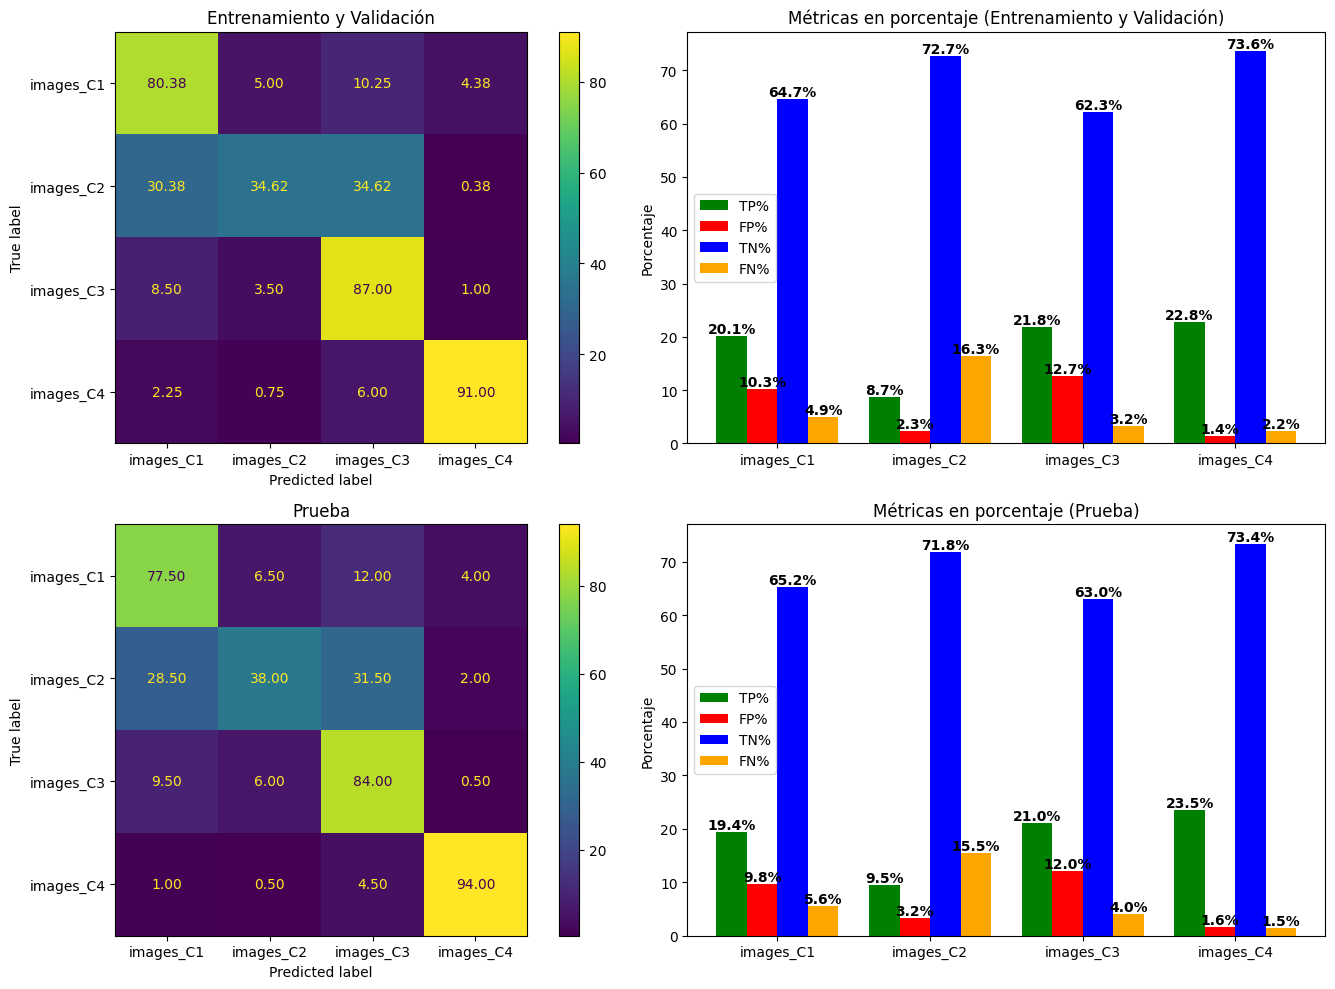

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

def calcular_métricas(y_true, y_pred, clases, title, ax_cm, ax_bar):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convertir a porcentaje
    
    print(f"\nMatriz de Confusión Normalizada ({title}):\n")
    print(np.round(cm_percent, 2))  # Imprimir la matriz en porcentaje
    
    # Mostrar matriz de confusión normalizada
    disp = ConfusionMatrixDisplay(cm_percent, display_labels=clases)
    disp.plot(ax=ax_cm, cmap="viridis", values_format=".2f")  # Mostrar valores en porcentaje
    ax_cm.set_title(title)
    
    # Calcular TP, FP, TN, FN por clase en porcentaje
    TP = np.diag(cm)  # Verdaderos Positivos
    FP = cm.sum(axis=0) - TP  # Falsos Positivos
    FN = cm.sum(axis=1) - TP  # Falsos Negativos
    TN = cm.sum() - (TP + FP + FN)  # Verdaderos Negativos
    
    total = cm.sum()  # Total de la matriz
    TP_percent = (TP / total) * 100
    FP_percent = (FP / total) * 100
    TN_percent = (TN / total) * 100
    FN_percent = (FN / total) * 100
    
    # Crear gráfico de barras con etiquetas de porcentaje
    bar_width = 0.2
    indices = np.arange(len(clases))
    
    bars_tp = ax_bar.bar(indices, TP_percent, bar_width, label="TP%", color='green')
    bars_fp = ax_bar.bar(indices + bar_width, FP_percent, bar_width, label="FP%", color='red')
    bars_tn = ax_bar.bar(indices + 2 * bar_width, TN_percent, bar_width, label="TN%", color='blue')
    bars_fn = ax_bar.bar(indices + 3 * bar_width, FN_percent, bar_width, label="FN%", color='orange')

    ax_bar.set_xticks(indices + bar_width * 1.5)
    ax_bar.set_xticklabels(clases)
    ax_bar.set_title(f'Métricas en porcentaje ({title})')
    ax_bar.set_ylabel("Porcentaje")
    ax_bar.legend()

    # Agregar etiquetas de porcentaje en cada barra
    def agregar_etiquetas(bars):
        for bar in bars:
            height = bar.get_height()
            ax_bar.text(
                bar.get_x() + bar.get_width() / 2, 
                height, 
                f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold'
            )

    agregar_etiquetas(bars_tp)
    agregar_etiquetas(bars_fp)
    agregar_etiquetas(bars_tn)
    agregar_etiquetas(bars_fn)

# Configurar subgráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Matriz 2x2: 2 Matrices de Confusión + 2 Gráficos de Barras

# ENTRENAMIENTO Y VALIDACIÓN
print("\nENTRENAMIENTO Y VALIDACIÓN:")
y_pred_train = np.argmax(modelo.predict(X_train), axis=1)
print(classification_report(y_train, y_pred_train, target_names=clases))
calcular_métricas(y_train, y_pred_train, clases, "Entrenamiento y Validación", axes[0, 0], axes[0, 1])

# PRUEBA
print("\nPRUEBA:")
y_pred_test = np.argmax(modelo.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_test, target_names=clases))
calcular_métricas(y_test, y_pred_test, clases, "Prueba", axes[1, 0], axes[1, 1])

plt.tight_layout()
plt.show()
